<a href="https://colab.research.google.com/github/JoaoLucasAbreu/Forecasting_Data/blob/main/Ethereum_Trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling long-term changes with moving averages and the time dummy

The trend component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

## Moving Average Plots


To see what kind of trend a time series might have, it's possible to use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

To visualize a trend, therefore, we take an average over a period longer than any seasonal period in the series.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


In [ ]:
eth_df = pd.read_csv('/content/drive/MyDrive/csv_files/Ethereum_Historical_Data.csv',
                     parse_dates=['Date'],
                     index_col='Date',
                     ).to_period('D')

eth_df 

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2016-03-10,11.75,11.20,11.85,11.07,0.00K,4.91%
2016-03-11,11.95,11.75,11.95,11.75,0.18K,1.70%
2016-03-12,12.92,11.95,13.45,11.95,0.83K,8.12%
2016-03-13,15.07,12.92,15.07,12.92,1.30K,16.64%
2016-03-14,12.50,15.07,15.07,11.40,92.18K,-17.05%
...,...,...,...,...,...,...
2021-05-08,"3,905.55","3,479.81","3,952.88","3,453.37",1.34M,12.19%
2021-05-09,"3,922.23","3,905.69","3,979.77","3,734.44",1.94M,0.43%
2021-05-10,"3,947.90","3,923.48","4,203.98","3,669.84",2.70M,0.65%


In [ ]:
eth_df.shape

(1890, 6)

In [ ]:
eth_price = eth_df.loc[:, 'Price']
eth_price

Date
2016-03-10       11.75
2016-03-11       11.95
2016-03-12       12.92
2016-03-13       15.07
2016-03-14       12.50
                ...   
2021-05-08    3,905.55
2021-05-09    3,922.23
2021-05-10    3,947.90
2021-05-11    4,167.78
2021-05-12    4,241.19
Freq: D, Name: Price, Length: 1890, dtype: object

In [ ]:
eth_price = eth_price.str.replace(',', '').astype(float)

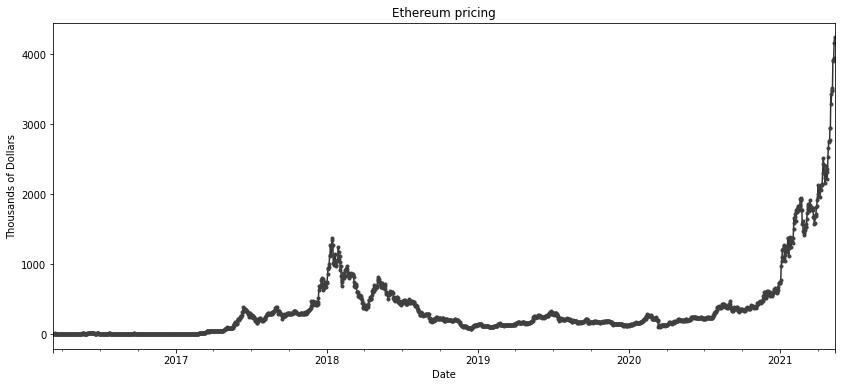

In [ ]:
plot_params = {
 'color': '0.2',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}
 
plt.figure(figsize = (14, 6))
ax = eth_price.plot(**plot_params)
ax.set(title="Ethereum pricing", ylabel="Thousands of Dollars");

## Moving Average Plot

To create a moving average, first use the rolling method to begin a windowed computation. Follow this by the mean method to compute the average over the window. 

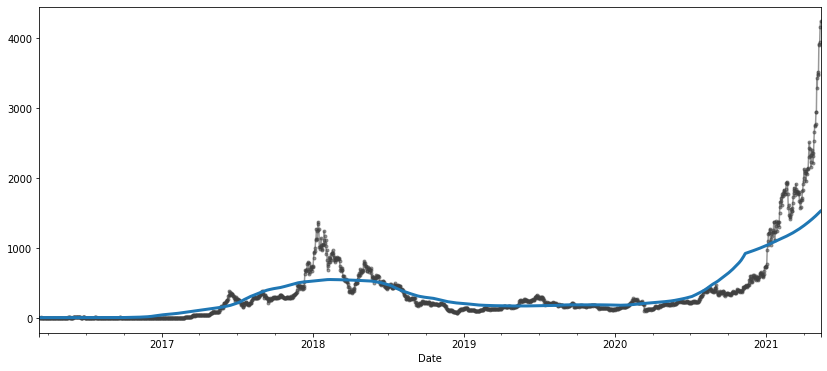

In [ ]:
trend = eth_price.rolling(
    window = 365,       # 365-day window
    center = True,      # puts the average at the center of the window
    min_periods = 184   # choose about half the window size
    ).mean()            # compute the mean (could also do median, std, min, max, ...)

plt.figure(figsize = (14, 6))
ax = eth_price.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

## Trend Feature

Use DeterministicProcess to create a feature set for a cubic trend model. Also create features for a 90-day forecast.

In [ ]:
# Installing Statsmodels
!pip install statsmodels

In [ ]:
# Installing Statsmodels
pip install statsmodels==0.13.0

SyntaxError: ignored

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = eth_price.copy()  # the target

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,
    order=3
    )

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast
X_fore = dp.out_of_sample(steps = 120)

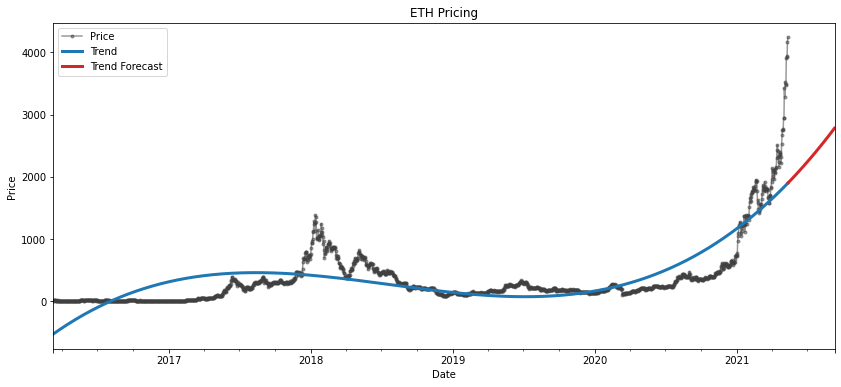

In [ ]:
model = LinearRegression()

model.fit(X, y)

y_pred = pd.Series(model.predict(X), index = X.index)
y_fore = pd.Series(model.predict(X_fore), index = X_fore.index)

plt.figure(figsize = (14, 6))
ax = y.plot(**plot_params, alpha = 0.5, title = 'ETH Pricing', ylabel="Price" )
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

## Splines

Splines are a nice alternative to polynomials when you want to fit a trend. The Multivariate Adaptive Regression Splines (MARS) algorithm in the pyearth library is powerful and easy to use. There are a lot of hyperparameters you may want to investigate.